In [94]:
 # Import libraries and dependencies
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import matplotlib.pyplot as plt
%matplotlib inline



In [95]:
ticker = 'VOO'


In [96]:
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = get_historical_data(ticker, start_date, end_date,  output_format='pandas')
df.tail()

,open,high,low,close,volume
date,,,,,
2019-09-10,273.11,273.88,271.87,273.87,1870384
2019-09-11,274.15,275.84,273.50,275.84,2080323
2019-09-12,276.71,277.80,275.94,276.65,2433713
2019-09-13,277.21,277.54,276.15,276.58,2292208
2019-09-16,275.38,276.10,275.04,275.67,1432383


In [97]:
 # Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df.head()


,close
date,
2018-09-17,265.85
2018-09-18,267.30
2018-09-19,267.60
2018-09-20,269.75
2018-09-21,269.56


In [98]:
daily_returns_df = df.pct_change()
log_returns_df = np.log(1 + daily_returns_df).dropna()
log_returns_df

,close
date,
2018-09-18,0.005439
2018-09-19,0.001122
2018-09-20,0.008002
2018-09-21,-0.000705
2018-09-24,-0.003344
...,...
2019-09-10,0.000219
2019-09-11,0.007167
2019-09-12,0.002932


In [123]:
  
def mcs_brownian (df, num_simulations):
# Monte Carlo Simulation with Geometric Brownian Motion
# simulated_price = previous_day_price * exp((daily_returns_mean - ((daily_std_mean**2)/2)) + (daily_std_mean * random_noise ))
    
    daily_returns_df = df.pct_change()
    log_returns_df = np.log(1 + daily_returns_df).dropna()
    log_returns_mean = log_returns_df.mean()['close']
    log_returns_std_mean = log_returns_df.std()['close']
    
    simulations = num_simulations
    trading_days = 7560
    df_last_price = df['close'][-1]
    timestep = 1
    
    simulated_price_df = pd.DataFrame()
    portfolio_cumulative_returns = pd.DataFrame()
    
    for n in range(simulations):
        
        simulated_prices = [df_last_price]
        
        for i in range (trading_days):
            drift = log_returns_mean - (0.5*log_returns_std_mean**2)*timestep
            random_noise = np.random.normal()
            diffusion = (log_returns_std_mean * random_noise * timestep**0.5)
    
            simulated_price = simulated_prices[-1] * np.exp(drift + diffusion)
            simulated_prices.append(simulated_price)
            
        simulated_price_df = pd.Series(simulated_prices)
        simulated_daily_returns = simulated_price_df.pct_change()

        portfolio_cumulative_returns[n] = (1 + simulated_daily_returns.fillna(0)).cumprod()
    return portfolio_cumulative_returns
    

In [124]:
simulated_df = mcs_brownian(df,100)

In [125]:
simulated_df.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005174,1.013112,1.012397,1.005112,0.999068,0.988802,0.986502,0.974120,1.022761,0.994039,...,0.999748,1.014285,0.997415,1.004882,1.012017,0.972724,0.987601,1.001406,1.010513,0.977435
2,1.008578,1.001173,1.016481,1.005204,1.002453,1.005887,0.974608,0.977738,1.034533,0.988524,...,0.988995,1.014854,0.997045,1.010197,1.012841,0.968257,0.990909,0.990896,1.031486,0.987253
3,1.016360,1.001361,0.992178,1.003969,1.001915,1.001498,0.959149,0.987220,1.017673,0.971617,...,0.980705,1.029595,0.979169,1.008436,1.010987,0.953473,1.005034,0.988184,1.012237,0.989864
4,1.005077,1.009210,0.998226,0.983194,0.992059,1.022544,0.954286,0.985184,1.002344,0.948944,...,0.996353,1.018366,0.973284,1.002267,1.016015,0.976085,1.004784,0.995171,0.997833,0.996722


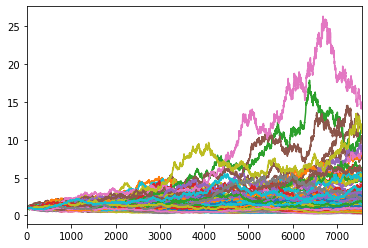

In [126]:
simulated_df.plot(legend=None)

In [127]:
ending_returns_simulated_df = simulated_df.iloc[-1, :]
ending_returns_simulated_df.head()

0    1.564345
1    1.763724
2    1.144929
3    1.397397
4    0.738887
Name: 7560, dtype: float64

In [128]:
confidence_interval = ending_returns_simulated_df.quantile(q=[0.025, 0.975])
confidence_interval

0.025     0.330053
0.975    11.051502
Name: 7560, dtype: float64

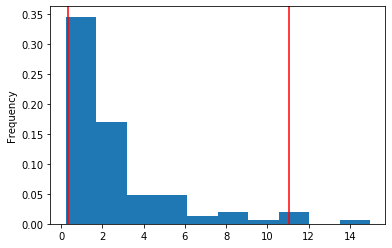

In [129]:
plt.figure();
ending_returns_simulated_df.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')